# <center>Application of Ant Colony Optimization and Artificial Bee Colony in FSP problem</center>

This notebook presents a practical approach to solving the flowshop problem by implementing the Ant Colony Optimization algorithm. These metaheuristics are effective in generating high-quality solutions for large instances of the problem, requiring only a reasonable amount of computational resources. Compared to heuristics, such metaheuristics are more effective for solving the flowshop problem because they can escape from local optima and find better solutions




## Data utils

In [91]:
import numpy as np
import random
import time
import math
import pandas as pd
import matplotlib.pyplot as plt

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

from utils.benchmarks import benchmarks, upper_bound
from utils.heuristics import *

### Path Cost calculation function :
Used to calculate the cost of current node, which is the correct cost starting for the actual path of executed jobs

In [2]:
def calculate_makespan(processing_times, sequence):
    n_jobs = len(sequence)
    n_machines = len(processing_times[0])
    end_time = [[0] * (n_machines + 1) for _ in range(n_jobs + 1)]

    for j in range(1, n_jobs + 1):
        for m in range(1, n_machines + 1):
            end_time[j][m] = max(end_time[j][m - 1], end_time[j - 1]
                                 [m]) + processing_times[sequence[j - 1]][m - 1]

    return end_time[n_jobs][n_machines]

### Gantt graph generator

In [86]:
def generate_gantt_chart(processing_times, seq, interval=50, labeled=True):
    data = processing_times.T
    nb_jobs, nb_machines = processing_times.shape
    schedules = np.zeros((nb_machines, nb_jobs), dtype=dict)
    # schedule first job alone first
    task = {"name": "job_{}".format(
        seq[0]+1), "start_time": 0, "end_time": data[0][seq[0]]}

    schedules[0][0] = task
    for m_id in range(1, nb_machines):
        start_t = schedules[m_id-1][0]["end_time"]
        end_t = start_t + data[m_id][0]
        task = {"name": "job_{}".format(
            seq[0]+1), "start_time": start_t, "end_time": end_t}
        schedules[m_id][0] = task

    for index, job_id in enumerate(seq[1::]):
        start_t = schedules[0][index]["end_time"]
        end_t = start_t + data[0][job_id]
        task = {"name": "job_{}".format(
            job_id+1), "start_time": start_t, "end_time": end_t}
        schedules[0][index+1] = task
        for m_id in range(1, nb_machines):
            start_t = max(schedules[m_id][index]["end_time"],
                          schedules[m_id-1][index+1]["end_time"])
            end_t = start_t + data[m_id][job_id]
            task = {"name": "job_{}".format(
                job_id+1), "start_time": start_t, "end_time": end_t}
            schedules[m_id][index+1] = task

    # create a new figure
    fig, ax = plt.subplots(figsize=(18, 8))

    # set y-axis ticks and labels
    y_ticks = list(range(len(schedules)))
    y_labels = [f'Machine {i+1}' for i in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)

    # calculate the total time
    total_time = max([job['end_time'] for proc in schedules for job in proc])

    # set x-axis limits and ticks
    ax.set_xlim(0, total_time)
    x_ticks = list(range(0, total_time+1, interval))
    ax.set_xticks(x_ticks)

    # set grid lines
    ax.grid(True, axis='x', linestyle='--')

    # create a color dictionary to map each job to a color
    color_dict = {}
    for proc in schedules:
        for job in proc:
            if job['name'] not in color_dict:
                color_dict[job['name']] = (np.random.uniform(
                    0, 1), np.random.uniform(0, 1), np.random.uniform(0, 1))

    # plot the bars for each job on each processor
    for i, proc in enumerate(schedules):
        for job in proc:
            start = job['start_time']
            end = job['end_time']
            duration = end - start
            color = color_dict[job['name']]
            ax.barh(i, duration, left=start, height=0.5,
                    align='center', color=color, alpha=0.8)
            if labeled:
                # add job labels
                label_x = start + duration/2
                label_y = i
                ax.text(
                    label_x, label_y, job['name'][4:], ha='center', va='center', fontsize=10)

    plt.show()

### ACO for FSP

In [101]:
class AntColonyOptimization:

    def __init__(self, processingTimes, Alpha=.5, Beta=.5, Q=.9, max_it=10, num_ant=16, rho=0, heuristicSolution =[]) -> None:

        self.numberJobs = processingTimes.shape[0]
        self.numberMachines = processingTimes.shape[1]
        self.Distances = np.zeros((self.numberJobs, self.numberJobs))
        self.processingTimes = processingTimes
        self.archive = heuristicSolution
        self.alpha = Alpha
        self.beta = Beta
        self.Q = Q
        self.globalPheromone = np.ones((self.numberJobs, self.numberJobs))
        self.maxIt = max_it
        self.numAnt = num_ant
        self.rho = rho


    def calculateDistances(self):
        for i in range(self.numberJobs):
            for j in range(self.numberJobs):
                if (i == j):
                    self.Distances[i, j] =0
                else :
                    #self.Distances[i, j] = calculate_makespan(self.processingTimes, [i,j]) - calculate_makespan(self.processingTimes, [i])
                    #self.Distances[i, j] = calculate_makespan(self.processingTimes, [i,j])
                    self.Distances[i, j] = calculate_makespan(self.processingTimes, [j,i])


    # calcule la formule de choix du job à prendre 
    def calculateJobVoisin(self, jobCourant, lePotentielJobVoisin, lesPotentielsJobsVoisins):
        denominateur = 0
        numerateur = 0

        for i in range(len(lesPotentielsJobsVoisins)):
            denominateur += (self.globalPheromone[jobCourant, lesPotentielsJobsVoisins[i]])**self.alpha * (1/self.Distances[jobCourant, lesPotentielsJobsVoisins[i]])**self.beta
        numerateur =  (self.globalPheromone[jobCourant, lePotentielJobVoisin])**self.alpha * (1/self.Distances[jobCourant, lePotentielJobVoisin])**self.beta

        return numerateur/denominateur


    def updateLocalPheromone(self, solutionSequence, localPheromoneMatrix):

        solutionQuality = calculate_makespan(self.processingTimes, solutionSequence)

        for j in range(len(solutionSequence)-1):

            localPheromoneMatrix[solutionSequence[j], solutionSequence[j+1]] += self.Q /solutionQuality
   

    def updateGlobalPheromone(self, localPheromoneMatrix):

        self.globalPheromone = (1-self.rho)*self.globalPheromone + localPheromoneMatrix          
    

    def run(self):

        start_time = time.time()

        self.calculateDistances()

        for it in range(self.maxIt):

            #liste de liste pour contenir les solutions de chaque fourmi

            solutions = []

            localPheromone = np.zeros((self.numberJobs, self.numberJobs))


            for ant in range(self.numAnt): 

                solutions.append([])

                num_job_pris = 0

                #initialisation de la liste contenant les jobs qui constitueront la solution, elle sera updaté à chaque fois qu'un job est pris

                job_dispo = list(range(self.numberJobs))

                # démarrer par un job aléatoirement

                solutions[ant].append(job_dispo[random.randint(0, len(job_dispo) - 1)])
                

                #updating ce qu'il faut

                job_dispo.remove(solutions[ant][num_job_pris])

                num_job_pris +=1

                while(len(job_dispo)>0): # équivaut à dire num_job_pris < self.numberJobs

                    bestVoisin = 0

                    nextJob = None

                    for i in range(len(job_dispo)):

                        #solutions[ant][num_job_pris-1] is the current node

                        voisinActuel = self.calculateJobVoisin(solutions[ant][num_job_pris-1], job_dispo[i], job_dispo)

                        if( voisinActuel > bestVoisin):

                            bestVoisin = voisinActuel

                            nextJob = job_dispo[i]


                    solutions[ant].append(nextJob)

                    #updating ce qu'il faut

                    job_dispo.remove(nextJob)

                    num_job_pris +=1

                #Mise à jour local de phéromone

                self.updateLocalPheromone(solutions[ant], localPheromone) 

                # print("Ant : ", ant, "'s solution : ", solutions[ant]) 

                # print("Its makespan is : ", calculate_makespan(self.processingTimes, solutions[ant]))

            #Mise à jour globale de phéromone 

            self.updateGlobalPheromone(localPheromone)

            # L'idée que j'ai est de calculer le makespan de toutes les solutions et si une est meilleure de celle contenu dans l'archive l'archiver à son tour 

            for sol in range(len(solutions)):

                makespan = calculate_makespan(self.processingTimes, solutions[sol])

                if (makespan < calculate_makespan(self.processingTimes, self.archive)):

                    self.archive = solutions[sol]
                
        print("Elapsed time:", time.time()-start_time, "seconds")

        #Retourner la meilleure solution 

        return self.archive  


In [26]:
algorithms = {
    "NEH":  neh_algorithm,
    "Ham":  ham_heuristic,
    "CDS":  cds_heuristic,
    "Gupta": gupta_heuristic,
    "Palmer":  run_palmer,
    "PRSKE":  PRSKE,
    "Weighted CDS": special_heuristic,
    "NRH": NRH,
    "Chen": chen_heuristic
    }


In [8]:
def generate_heuristic_solution(processing_times ,name = "NEH" ):
    return algorithms[name](processing_times)[0]

## Tests

In [127]:

processing_times = benchmarks[0]
initial_solution = generate_heuristic_solution(processing_times , "PRSKE")

print("Initial solution : ", initial_solution)
print("Makespan : ", calculate_makespan(processing_times, initial_solution))

ACO = AntColonyOptimization(processing_times, Alpha=10, Beta=1, Q=1, max_it=1, num_ant=1, rho=0, heuristicSolution=initial_solution)
result = ACO.run()

print("Solution : ",result)
print("Makespann " , calculate_makespan(processing_times, result))

Initial solution :  [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2]
Makespan :  1593
Elapsed time: 0.007054567337036133 seconds
Solution :  [4, 12, 2, 16, 14, 7, 8, 13, 19, 11, 10, 18, 5, 9, 6, 0, 1, 17, 15, 3]
Makespann  1423


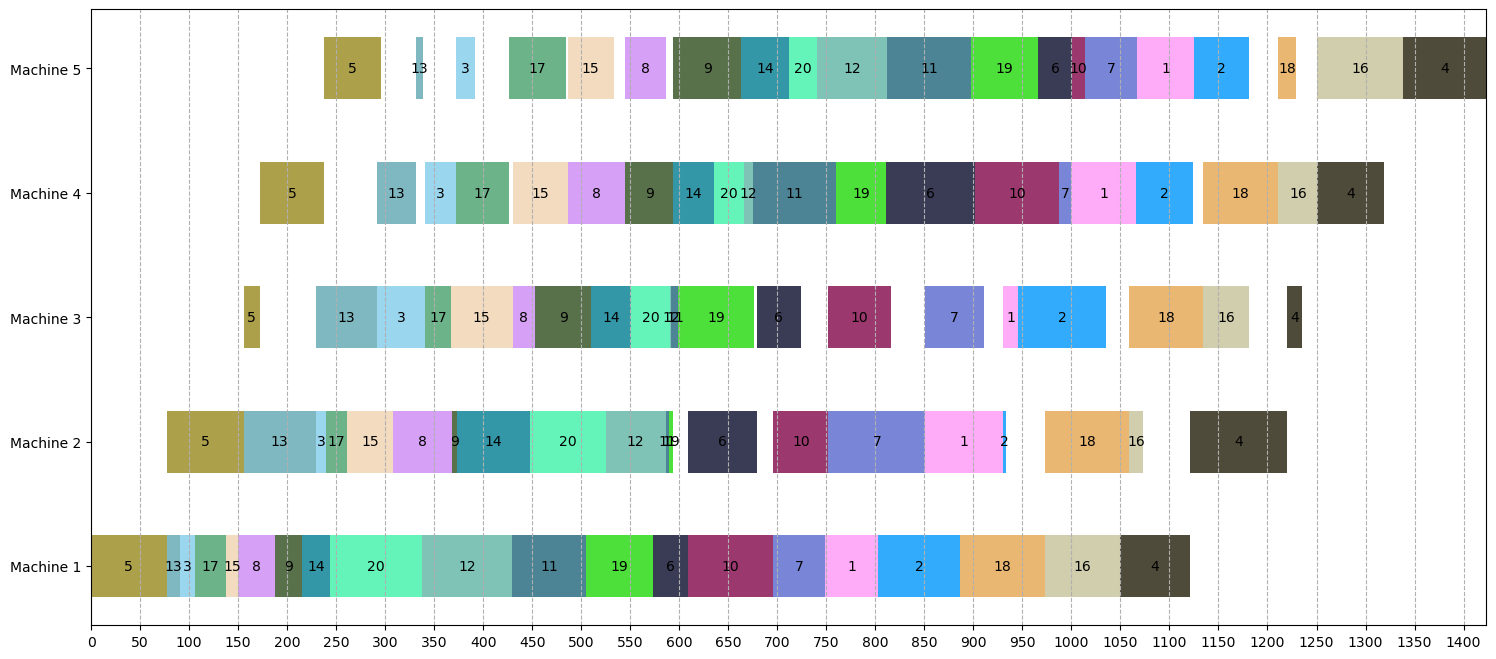

In [128]:
generate_gantt_chart(processing_times,result)

## Meilleurs Hyper Parameters

In [44]:
processing_times = benchmarks[0]
initial_solution = generate_heuristic_solution(processing_times , "PRSKE")

print("Initial solution : ", initial_solution)
print("Makespan : ", calculate_makespan(processing_times, initial_solution))
# Définir l'espace des paramètres
space = [
    Real(0.4, 0.9, name='alpha'),
    Real(0.1, 0.9, name='Q'),
    Integer(10, 200, name='it_max'),
    Integer(10, 200, name='num_ant'),
    Real(0.1, 0.9, name='rho'),
]

# Fonction objectif à minimiser


@use_named_args(space)
def objective(**params):
    alpha = params['alpha']
    Q = params['Q']
    it_max = params['it_max']
    num_ant = params['num_ant']
    rho = params['rho']
   

    ACO = AntColonyOptimization(
    processing_times, Alpha=alpha, Beta=1-alpha, Q=Q, max_it=it_max, num_ant=num_ant, rho=rho, heuristicSolution=initial_solution)
    
    result = ACO.run()
    res_makespane = calculate_makespan(processing_times, result)
    print(res_makespane)
    return res_makespane


# Lancer l'optimisation
result = gp_minimize(objective, space, n_calls=20, random_state=0)
# Affichage des meilleurs paramètres trouvés

best_alpha = result.x[0]
best_Q = result.x[1]
best_it_max = result.x[2]
best_num_ant = result.x[3]
best_rho = result.x[4]


Initial solution :  [3, 17, 10, 1, 9, 11, 6, 4, 19, 15, 18, 5, 0, 12, 8, 13, 14, 7, 16, 2]
Makespan :  1593
Elapsed time: 53.90149903297424 seconds
1377
Elapsed time: 2.376929759979248 seconds
1324
Elapsed time: 26.182218074798584 seconds
1377
Elapsed time: 12.79313588142395 seconds
1324
Elapsed time: 29.14049792289734 seconds
1377
Elapsed time: 9.198846101760864 seconds
1324
Elapsed time: 3.4675710201263428 seconds
1324
Elapsed time: 27.496704816818237 seconds
1324
Elapsed time: 10.376332998275757 seconds
1377
Elapsed time: 37.463818073272705 seconds
1324
Elapsed time: 2.962334156036377 seconds
1324
Elapsed time: 39.90258193016052 seconds
1324
Elapsed time: 4.061922073364258 seconds
1377
Elapsed time: 8.625144958496094 seconds
1358
Elapsed time: 58.308162689208984 seconds
1324
Elapsed time: 2.324167251586914 seconds
1377
Elapsed time: 25.24886918067932 seconds
1358
Elapsed time: 7.35469913482666 seconds
1324
Elapsed time: 9.94289493560791 seconds
1324
Elapsed time: 8.379739761352539 s

In [45]:
best_alpha = result.x[0]
best_Q = result.x[1]
best_it_max = result.x[2]
best_num_ant = result.x[3]
best_rho = result.x[4]

ACO = AntColonyOptimization(

    processing_times, Alpha=best_alpha, Beta=1-best_alpha, Q=best_Q, max_it=best_it_max, num_ant=best_num_ant, rho=best_rho, heuristicSolution=initial_solution)

result = ACO.run()

print("Solution : ", result)
print("Makespann ", calculate_makespan(processing_times, result))

Elapsed time: 2.368870973587036 seconds
Solution :  [3, 14, 2, 16, 8, 7, 13, 12, 15, 10, 11, 18, 0, 1, 5, 6, 9, 4, 17, 19]
Makespann  1324


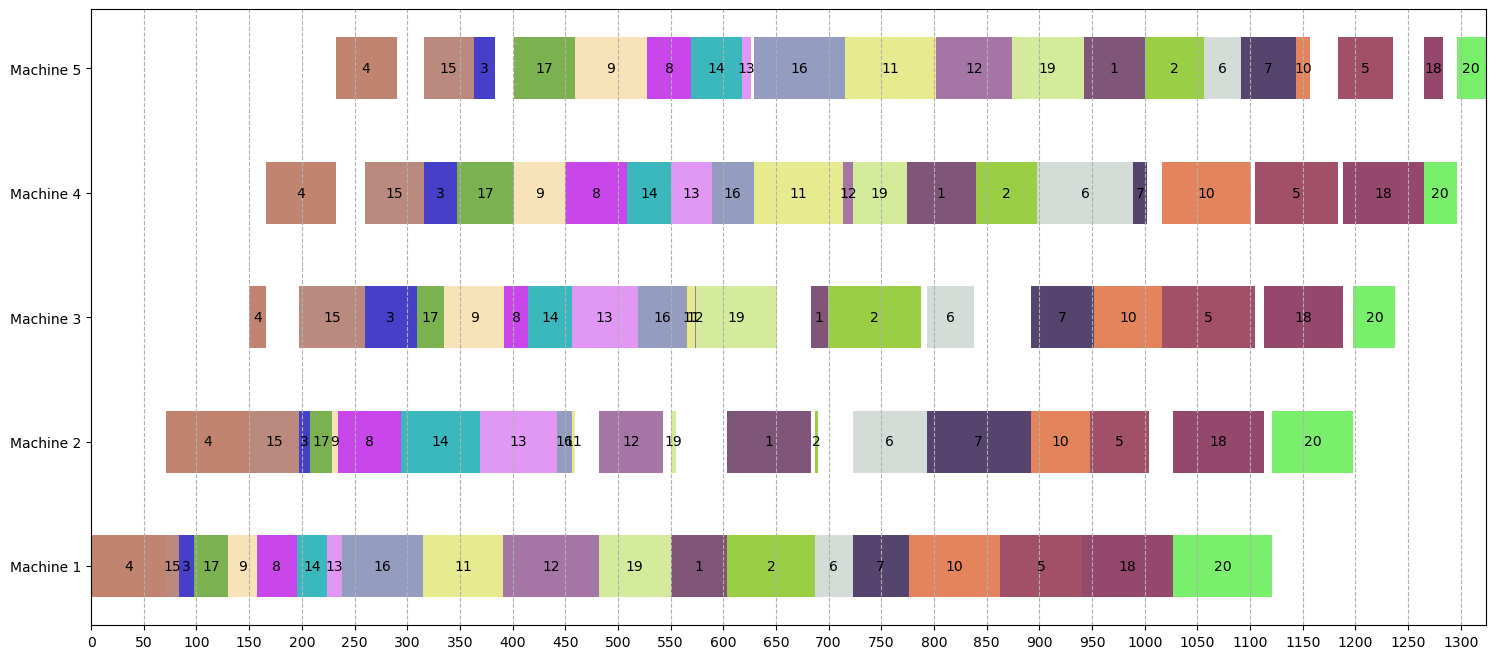

In [46]:
generate_gantt_chart(processing_times,result)

# Artificial Bee Colony for FSP

In [103]:
class ArtificialBeeColony:
    def __init__(self, ProcessingTimes, MaxIt=200, nPop=100, nOnlooker=None, L=None):
        self.ProcessingTimes = ProcessingTimes
        self.MaxIt = MaxIt
        self.nPop = nPop
        self.nOnlooker = nOnlooker if nOnlooker is not None else nPop
        self.L = L if L is not None else round(0.6 * self.ProcessingTimes.shape[0] * nPop)
    
    def update_solution(self, A, B, psi):
        a_solution, a_cost = A["Solution"], A["Cost"]
        b_solution, b_cost = B["Solution"], B["Cost"]
        intermediate_solution = a_solution.copy()
        BestSol_l = {'Solution': [], "Cost": float('inf')}
        #print('==========================================================================================')
        #print('A: ', a_solution, a_cost)
        #print('B: ', b_solution, b_cost)
        i = 0
        while i < len(b_solution)-2:
            if psi < 0.5:
                i_i_index = intermediate_solution.index(b_solution[i])
                b_i_index = i
            else:
                b_i_index = b_solution.index(i)
                i_i_index = intermediate_solution.index(i)
            if b_i_index != i_i_index:
                intermediate_solution[b_i_index], intermediate_solution[i_i_index] = intermediate_solution[i_i_index], intermediate_solution[b_i_index]
                intermediate_cost = calculate_makespan(self.ProcessingTimes, intermediate_solution)
                if intermediate_cost < BestSol_l["Cost"]:
                    BestSol_l["Solution"] = intermediate_solution.copy()
                    BestSol_l["Cost"] = intermediate_cost
            i+=1
                
        return BestSol_l
    
    def run(self):
        # Initialization
        pop = self.initialize_population()
        print(min(pop, key=lambda x: x['Cost']))
        BestSol = min(pop, key=lambda x: x['Cost'])
        C = np.zeros(self.nPop)
        BestCost = np.zeros(self.MaxIt)
        
        # ABC Main Loop
        for it in range(self.MaxIt):
            # Recruited Bees
            for i in range(self.nPop):
                K = list(range(i)) + list(range(i+1, self.nPop))
                k = np.random.choice(K)
                psi = np.random.uniform(-1, 1)
                if psi < 0:
                    newbee = self.update_solution(pop[k], pop[i], abs(psi))
                else:
                    newbee = self.update_solution(pop[i], pop[k], abs(psi))
                
                if newbee['Cost'] < pop[i]['Cost']:
                    pop[i] = newbee
                else:
                    C[i] += 1
            
            # Calculate Fitness Values and Selection Probabilities
            F = np.exp(-np.array([x['Cost'] for x in pop]) / np.mean([x['Cost'] for x in pop]))
            P = F / np.sum(F)
            
            # Onlooker Bees
            for m in range(self.nOnlooker):
                #i = self.roulette_wheel_selection(P)
                i = np.argmax(P)
                P[i] = -np.inf
                K = list(range(i)) + list(range(i+1, self.nPop))
                k = np.random.choice(K)
                psi = np.random.uniform(-1, 1)
                if psi < 0:
                    newbee = self.update_solution(pop[k], pop[i], abs(psi))
                else:
                    newbee = self.update_solution(pop[i], pop[k], abs(psi))
                    
                if newbee['Cost'] < pop[i]['Cost']:
                    pop[i] = newbee
                else:
                    C[i] += 1
            
            # Scout Bees
            for i in range(self.nPop):
                if C[i] >= self.L:
                    pop[i] = {'Solution': self.initialize_a_solution()}
                    pop[i]['Cost'] = calculate_makespan(self.ProcessingTimes, pop[i]['Solution'])
                    C[i] = 0
            
            # Update Best Solution Ever Found
            BestSol = min(pop + [BestSol], key=lambda x: x['Cost'])
            # Store Best Cost Ever Found
            BestCost[it] = BestSol['Cost']
            
            # Display Iteration Information
            print(f"Iteration {it + 1}: Best Cost = {BestCost[it]}")
        
        return BestSol['Solution']
    
    def initialize_population(self):
        pop = []
        for _ in range(self.nPop):
            bee = {'Solution': self.initialize_a_solution()}
            bee['Cost'] = calculate_makespan(self.ProcessingTimes, bee['Solution'])
            pop.append(bee)
        return pop
    
    def initialize_a_solution(self):
        def random_solution(processing_times):
            n_jobs = processing_times.shape[0]
            solution = list(range(n_jobs))
            random.shuffle(solution)
            return solution, 0
            
        algorithms = {
            "NEH":  neh_algorithm,
            "Ham":  ham_heuristic,
            "CDS":  cds_heuristic,
            "Gupta": gupta_heuristic,
            "Palmer":  run_palmer,
            "PRSKE":  PRSKE,
            "Weighted CDS": special_heuristic,
            "NRH": NRH,
            "Chen": chen_heuristic,
            "random": random_solution
            }    
        def generate_heuristic_solution(processing_times ,name = "NEH" ):
            return algorithms[name](processing_times)[0]
        
        solution = generate_heuristic_solution(self.ProcessingTimes, name=random.choice(list(algorithms.keys())))
        return list(solution)
    
    def roulette_wheel_selection(self, P):
        r = np.random.rand()
        C = np.cumsum(P)
        for i in range(len(C)):
            if r <= C[i]:
                return i

## Tests

In [65]:
ABC = ArtificialBeeColony(benchmarks[0], MaxIt=200, nPop=100, nOnlooker=40, L=5)
BestSol, BestCost = ABC.run()

{'Solution': [10, 14, 3, 15, 18, 16, 5, 4, 0, 2, 12, 11, 1, 13, 8, 7, 17, 9, 6, 19], 'Cost': 1305}
Iteration 1: Best Cost = 1297.0
Iteration 2: Best Cost = 1297.0
Iteration 3: Best Cost = 1297.0
Iteration 4: Best Cost = 1297.0
Iteration 5: Best Cost = 1297.0
Iteration 6: Best Cost = 1297.0
Iteration 7: Best Cost = 1297.0
Iteration 8: Best Cost = 1297.0
Iteration 9: Best Cost = 1297.0
Iteration 10: Best Cost = 1297.0
Iteration 11: Best Cost = 1297.0
Iteration 12: Best Cost = 1297.0
Iteration 13: Best Cost = 1297.0
Iteration 14: Best Cost = 1297.0
Iteration 15: Best Cost = 1297.0
Iteration 16: Best Cost = 1291.0
Iteration 17: Best Cost = 1291.0
Iteration 18: Best Cost = 1291.0
Iteration 19: Best Cost = 1288.0
Iteration 20: Best Cost = 1288.0
Iteration 21: Best Cost = 1286.0
Iteration 22: Best Cost = 1286.0
Iteration 23: Best Cost = 1286.0
Iteration 24: Best Cost = 1286.0
Iteration 25: Best Cost = 1286.0
Iteration 26: Best Cost = 1286.0
Iteration 27: Best Cost = 1286.0
Iteration 28: Best 

In [49]:
ABC = ArtificialBeeColony(benchmarks[1], MaxIt=200, nPop=100, nOnlooker=40, L=5)
BestSol, BestCost = ABC.run()

{'Solution': [5, 6, 14, 11, 12, 10, 2, 15, 19, 3, 16, 0, 8, 1, 9, 7, 18, 4, 13, 17], 'Cost': 1367}
Iteration 1: Best Cost = 1366.0
Iteration 2: Best Cost = 1366.0
Iteration 3: Best Cost = 1366.0
Iteration 4: Best Cost = 1366.0
Iteration 5: Best Cost = 1366.0
Iteration 6: Best Cost = 1366.0
Iteration 7: Best Cost = 1366.0
Iteration 8: Best Cost = 1366.0
Iteration 9: Best Cost = 1366.0
Iteration 10: Best Cost = 1366.0
Iteration 11: Best Cost = 1366.0
Iteration 12: Best Cost = 1366.0
Iteration 13: Best Cost = 1366.0
Iteration 14: Best Cost = 1366.0
Iteration 15: Best Cost = 1366.0
Iteration 16: Best Cost = 1366.0
Iteration 17: Best Cost = 1366.0
Iteration 18: Best Cost = 1366.0
Iteration 19: Best Cost = 1366.0
Iteration 20: Best Cost = 1366.0
Iteration 21: Best Cost = 1366.0
Iteration 22: Best Cost = 1366.0
Iteration 23: Best Cost = 1366.0
Iteration 24: Best Cost = 1366.0
Iteration 25: Best Cost = 1366.0
Iteration 26: Best Cost = 1366.0
Iteration 27: Best Cost = 1366.0
Iteration 28: Best 

# Comparison Figure

In [109]:
algorithms = {
    "NEH":  neh_algorithm,
    "Ham":  ham_heuristic,
    "CDS":  cds_heuristic,
    "Gupta": gupta_heuristic,
    "Palmer":  run_palmer,
    "PRSKE":  PRSKE,
    "Weighted CDS": special_heuristic,
    "NRH": NRH,
    "Chen": chen_heuristic
    }

def generate_heuristic_solution(processing_times ,name = "NEH" ):
    return algorithms[name](processing_times)[0]

def run_all_algo(processing_times, upper_bound):

    heuristics = []

    def get_ACO(processing_times):
        initial_solution = generate_heuristic_solution(processing_times , "PRSKE")
        return AntColonyOptimization(processing_times, Alpha=0.5, Beta=0.5, Q=0.7, max_it=100, num_ant=40, rho=0.6, heuristicSolution=initial_solution)
    
    heuristics.append(('ACO', get_ACO(processing_times)))
    heuristics.append(('ABC', ArtificialBeeColony(processing_times, MaxIt=200, nPop=100, nOnlooker=40, L=5)))

    result = []
    for name, heuristic in heuristics:
        stat = []
        start_time = time.perf_counter()
        output = heuristic.run()
        end_time = time.perf_counter()
        elapsed_time = (end_time - start_time) * 1e6
        RDP = (( calculate_makespan(processing_times, output) - upper_bound )/ upper_bound ) * 100
        stat = (name, RDP, elapsed_time)
        result.append(stat)
    return result

In [113]:
def generate_histogram(tab_stats):
    RDP = [stat[1] for stat in tab_stats]
    Execution_time = [stat[2] for stat in tab_stats]
    fig, ax = plt.subplots(figsize=(18, 10))
    index = np.arange(len(tab_stats))
    bar_width = 0.35
    rects2 = ax.bar(index + bar_width, Execution_time, bar_width,
        color='#2A2359',
        label='Execution Time')
    rects1 = ax.bar(index, RDP, bar_width,
    color='#D9731A',
    label='RDP')
    ax.set_xlabel('Meta-Heuristics')
    ax.set_ylabel('RDP / Execution Time (us)')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels([stat[0] for stat in tab_stats])
    ax.legend()
    plt.show()

In [111]:
var = run_all_algo(benchmarks[0], upper_bound[0])

Elapsed time: 17.362011671066284 seconds
{'Solution': [10, 14, 3, 15, 18, 16, 5, 4, 0, 2, 12, 11, 1, 13, 8, 7, 17, 9, 6, 19], 'Cost': 1305}
Iteration 1: Best Cost = 1297.0
Iteration 2: Best Cost = 1297.0
Iteration 3: Best Cost = 1297.0
Iteration 4: Best Cost = 1297.0
Iteration 5: Best Cost = 1297.0
Iteration 6: Best Cost = 1297.0
Iteration 7: Best Cost = 1297.0
Iteration 8: Best Cost = 1297.0
Iteration 9: Best Cost = 1297.0
Iteration 10: Best Cost = 1297.0
Iteration 11: Best Cost = 1297.0
Iteration 12: Best Cost = 1297.0
Iteration 13: Best Cost = 1297.0
Iteration 14: Best Cost = 1297.0
Iteration 15: Best Cost = 1296.0
Iteration 16: Best Cost = 1294.0
Iteration 17: Best Cost = 1294.0
Iteration 18: Best Cost = 1294.0
Iteration 19: Best Cost = 1294.0
Iteration 20: Best Cost = 1294.0
Iteration 21: Best Cost = 1294.0
Iteration 22: Best Cost = 1294.0
Iteration 23: Best Cost = 1294.0
Iteration 24: Best Cost = 1294.0
Iteration 25: Best Cost = 1294.0
Iteration 26: Best Cost = 1294.0
Iteration 2

[('ACO', 3.599374021909233, 17361992.699999973), ('ABC', 0.0, 53723958.59999961)]


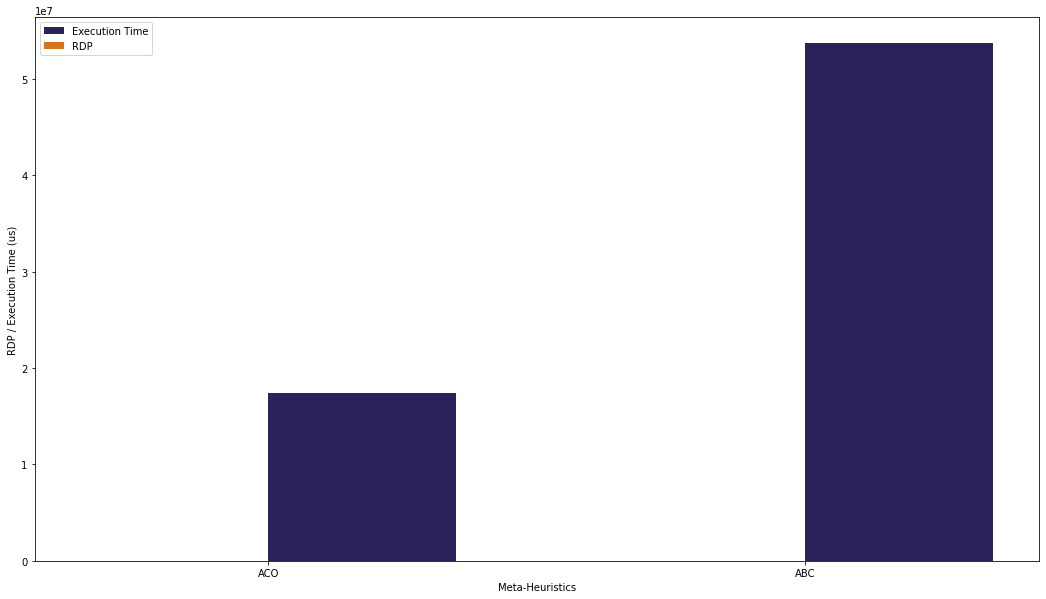

In [114]:
print(var)
generate_histogram(var)